# Sample SCRUF output processing
This file contains examples of processing and visualizating the output from a run of SCRUF.

## Imports

In [103]:
import pandas as pd
import numpy as np
import json
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sb

## Converting from JSON to data frame

In [157]:
def read_history(history_file):
    entries = []
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            entries.append(obj)
    return entries
                 
def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (compat_df.sum(axis=1) == 0).astype(int)
    else:
        alloc_df = None
    if lists:
        ballot_in = [process_results(entry['choice_in']['ballots']['__rec']['prefs']['results']) for entry in history]
        #results_in = [(entry['item'], entry['score']) for entry in ballot_in['prefs']['results']]
        results_out = [process_results(entry['choice_out']['results']) for entry in history]
        results_df = pd.DataFrame({'In': ballot_in, 'Out': results_out})
    else:
        results_list = None
        
    results_df = pd.concat([fair_df, compat_df, alloc_df, results_df], axis=1, 
                        keys=['Fairness', 'Compatibility', 'Allocation', 'Results'])
    
    return results_df

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]


In [223]:
history = read_history('sample_output.json')
output_df = process_history(history)

Note that it produces a DataFrame with a multilevel index for the columns

In [224]:
output_df.head()

Fairness           Compatibility           Allocation                 \
          1         2             1         2          1         2 none   
0  1.000000  1.000000      0.114800  0.289584   0.000000  0.000000    0   
1  0.000000  0.400000      0.285953  0.146948   0.863223  0.136777    0   
2  0.000000  0.200000      0.285499  0.161273   0.796639  0.203361    0   
3  0.266667  0.266667      0.158492  0.273498   0.251398  0.748602    0   
4  0.300000  0.200000      0.116212  0.265071   0.143971  0.856029    0   

                                             Results  \
                                                  In   
0  [(3484, 7.86710150118139), (2367, 6.3533447145...   
1  [(3961, 5.367536723913962), (590, 5.3552412436...   
2  [(3484, 5.705318104846835), (1607, 4.709806529...   
3  [(3816, 11.64300547825603), (663, 10.574952862...   
4  [(4042, 3.562563204046363), (4052, 3.016226929...   

                                                      
                                                 Out  
0  [(3484, 6.293681200945112), (2367, 5.082675771...  
1  [(3961, 4.29402937913117), (590, 4.28419299491...  
2  [(3484, 4.564254483877469), (3846, 4.207410604...  
3  [(3816, 9.314404382604826), (663, 8.4599622896...  
4  [(1416, 3.0140518966769028), (4042, 2.85005056...

## Time series visualizations

In [225]:
def plot_fairness_time(results_df, include_none=False, image_prefix=None):
    fair_df = results_df['Fairness']
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    if image_prefix is not None:
        image_file = image_prefix + '-fairness.png'
        plt.savefig(image_file)

def plot_allocation(results_df, include_none=False, image_prefix=None):
    alloc_df = results_df['Allocation']
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    if image_prefix is not None:
        image_file = image_prefix + '-allocation.png'
        plt.savefig(image_file)
        
def plot_compatibility(results_df, include_none=False, image_prefix=None):
    compat_df = results_df['Compatibility']
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=compat_df)
    if image_prefix is not None:
        image_file = image_prefix + '-compatibility.png'
        plt.savefig(image_file)

def plot_fairness_regret(results_df, include_none=False, image_prefix=None):
    fair_df = results_df['Fairness']
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    if image_prefix is not None:
        image_file = image_prefix + '-regret.png'
        plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_compatibility(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

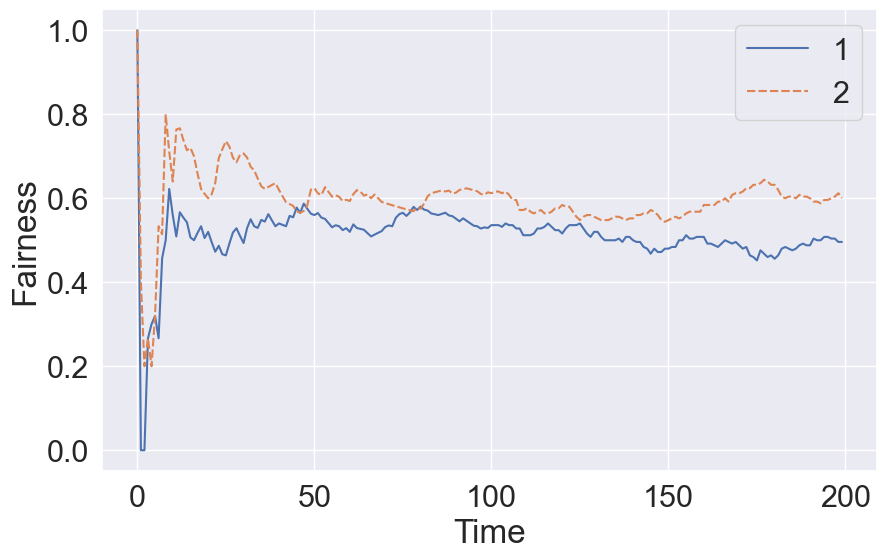

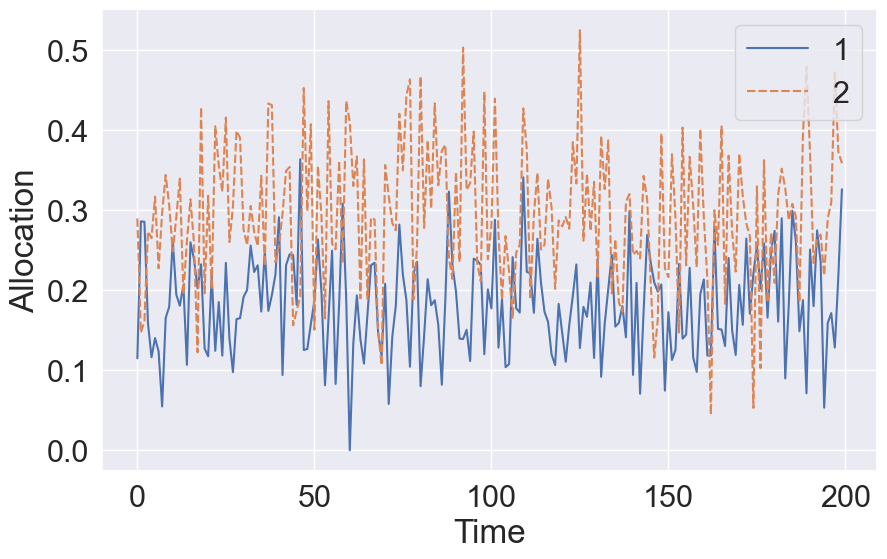

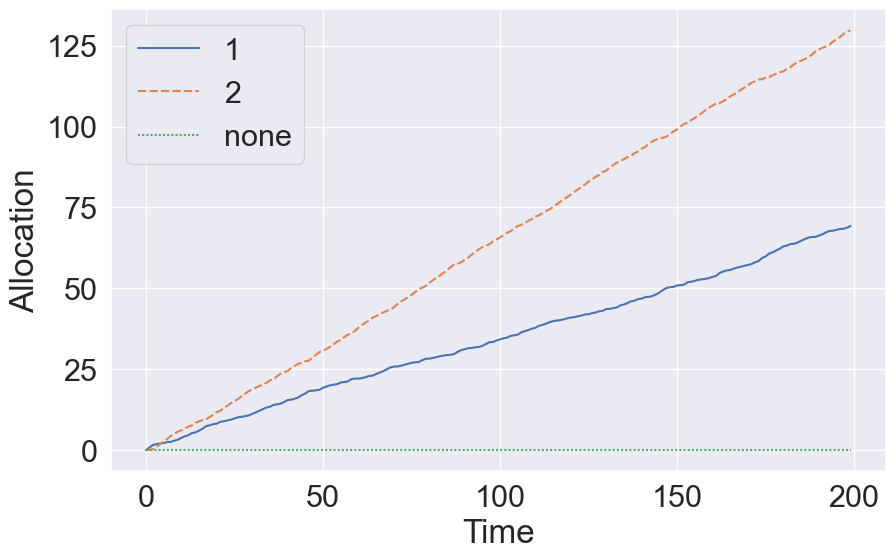

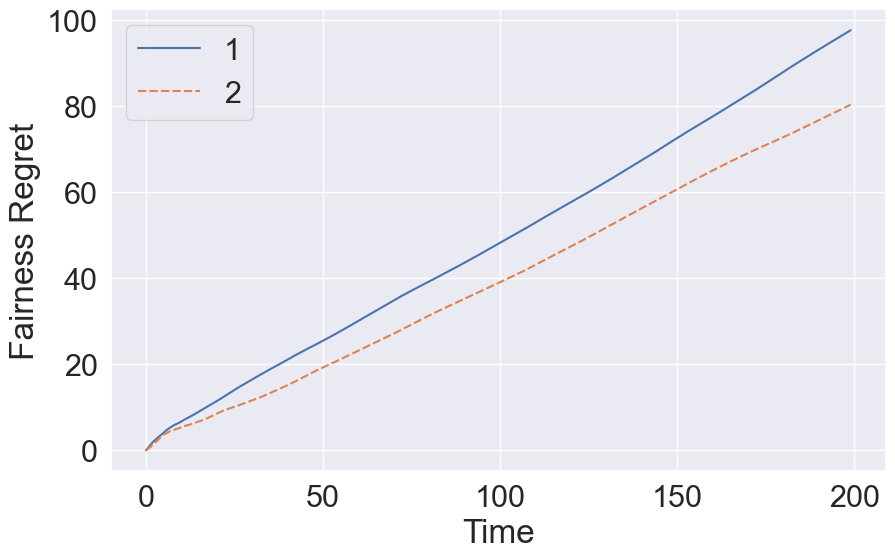

In [226]:
do_plots(output_df, include_none=True)

## Compute nDCG

In [227]:
# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

def results_to_ndcg(rec_list, result_list, length=10, threshold=np.NINF, binary=False):
    recommended = result_list[0:length]
    rec_rescore = substitute_scores(rec_list, recommended)
    ideal = rec_list[0:length]
    if binary:
        rec_thresh = [1 if score > threshold else 0 for item, score in rec_rescore]
        ideal_thresh = [1 if score > threshold else 0 for item, score in ideal]
    else:
        rec_thresh = [score if score > threshold else 0 for item, score in rec_rescore]
        ideal_thresh = [score if score > threshold else 0 for item, score in ideal]
    
    return ndcg(rec_thresh, ideal_thresh)

def substitute_scores(rec_list, result_list):
    score_dict = {entry[0]:entry[1] for entry in rec_list}
    rescored_results = [(entry[0], score_dict[entry[0]]) for entry in result_list]
    return rescored_results

In [228]:
output_df['nDCG'] = output_df['Results'].apply(lambda row: results_to_ndcg(row['In'], row['Out'], length=10), axis=1)

In [229]:
output_df.head()

Fairness           Compatibility           Allocation                 \
          1         2             1         2          1         2 none   
0  1.000000  1.000000      0.114800  0.289584   0.000000  0.000000    0   
1  0.000000  0.400000      0.285953  0.146948   0.863223  0.136777    0   
2  0.000000  0.200000      0.285499  0.161273   0.796639  0.203361    0   
3  0.266667  0.266667      0.158492  0.273498   0.251398  0.748602    0   
4  0.300000  0.200000      0.116212  0.265071   0.143971  0.856029    0   

                                             Results  \
                                                  In   
0  [(3484, 7.86710150118139), (2367, 6.3533447145...   
1  [(3961, 5.367536723913962), (590, 5.3552412436...   
2  [(3484, 5.705318104846835), (1607, 4.709806529...   
3  [(3816, 11.64300547825603), (663, 10.574952862...   
4  [(4042, 3.562563204046363), (4052, 3.016226929...   

                                                          nDCG  
                                                 Out            
0  [(3484, 6.293681200945112), (2367, 5.082675771...  1.000000  
1  [(3961, 4.29402937913117), (590, 4.28419299491...  1.000000  
2  [(3484, 4.564254483877469), (3846, 4.207410604...  0.950916  
3  [(3816, 9.314404382604826), (663, 8.4599622896...  1.000000  
4  [(1416, 3.0140518966769028), (4042, 2.85005056...  0.868141

<AxesSubplot:>

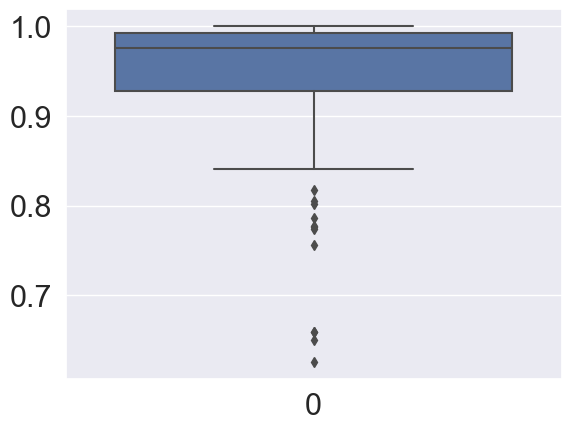

In [230]:
sb.boxplot(output_df.nDCG)

## Save the work

In [231]:
output_df.to_csv('sample_output.csv')